## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.3]
redice_lr_patient = [5, 10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 2s 32us/step - loss: 1.3628 - acc: 0.5261 - val_loss: 1.5473 - val_acc: 0.4588
Epoch 14/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.3422 - acc: 0.5343 - val_loss: 1.5393 - val_acc: 0.4625
Epoch 15/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.3231 - acc: 0.5417 - val_loss: 1.5317 - val_acc: 0.4650
Epoch 16/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.3045 - acc: 0.5487 - val_loss: 1.5278 - val_acc: 0.4662
Epoch 17/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.2875 - acc: 0.5553 - val_loss: 1.5144 - val_acc: 0.4777
Epoch 18/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.2692 - acc: 0.5623 - val_loss: 1.5160 - val_acc: 0.4761
Epoch 19/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.2537 - acc: 0.5691 - val_loss: 1.5106 - val_acc: 0.4713
Epoch 20/25
50000/50000 [=====================

50000/50000 [==============================] - 3s 53us/step - loss: 2.3635 - acc: 0.2300 - val_loss: 2.1733 - val_acc: 0.2878
Epoch 2/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.8625 - acc: 0.3509 - val_loss: 1.9189 - val_acc: 0.3384
Epoch 3/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.7267 - acc: 0.3950 - val_loss: 1.7744 - val_acc: 0.3799
Epoch 4/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.6507 - acc: 0.4215 - val_loss: 1.7304 - val_acc: 0.3937
Epoch 5/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.5965 - acc: 0.4399 - val_loss: 1.6731 - val_acc: 0.4087
Epoch 6/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.5538 - acc: 0.4542 - val_loss: 1.6489 - val_acc: 0.4196
Epoch 7/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.5182 - acc: 0.4675 - val_loss: 1.6214 - val_acc: 0.4282
Epoch 8/25
50000/50000 [============================

50000/50000 [==============================] - 2s 33us/step - loss: 0.4245 - acc: 0.8665 - val_loss: 1.9595 - val_acc: 0.4509
Epoch 25/25
50000/50000 [==============================] - 2s 33us/step - loss: 0.3963 - acc: 0.8766 - val_loss: 2.0336 - val_acc: 0.4498

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
__

50000/50000 [==============================] - 2s 33us/step - loss: 1.0316 - acc: 0.6471 - val_loss: 1.5059 - val_acc: 0.4709
Epoch 11/25
50000/50000 [==============================] - 2s 33us/step - loss: 0.9983 - acc: 0.6596 - val_loss: 1.4730 - val_acc: 0.4806
Epoch 12/25
50000/50000 [==============================] - 2s 33us/step - loss: 0.9609 - acc: 0.6746 - val_loss: 1.4724 - val_acc: 0.4874
Epoch 13/25
50000/50000 [==============================] - 2s 33us/step - loss: 0.9287 - acc: 0.6873 - val_loss: 1.4526 - val_acc: 0.4914
Epoch 14/25
50000/50000 [==============================] - 2s 33us/step - loss: 0.8965 - acc: 0.6986 - val_loss: 1.4510 - val_acc: 0.4946

Epoch 00014: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
Epoch 15/25
50000/50000 [==============================] - 2s 34us/step - loss: 0.8270 - acc: 0.7301 - val_loss: 1.3848 - val_acc: 0.5180
Epoch 16/25
50000/50000 [==============================] - 2s 34us/step - loss: 0.8036 - acc: 0.7406 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.8244 - acc: 0.3676 - val_loss: 1.8931 - val_acc: 0.3454
Epoch 2/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.5426 - acc: 0.4549 - val_loss: 1.9492 - val_acc: 0.3343
Epoch 3/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.4353 - acc: 0.4924 - val_loss: 2.3455 - val_acc: 0.2783
Epoch 4/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.3549 - acc: 0.5210 - val_loss: 4.7848 - val_acc: 0.1993
Epoch 5/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.2968 - acc: 0.5419 - val_loss: 2.0523 - val_acc: 0.3280
Epoch 6/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.2470 - acc: 0.5607 - val_loss: 1.8818 - val_acc: 0.3500
Epoch 7/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.2035 - acc: 0.5733 - val_loss: 1.9646 - val_acc

50000/50000 [==============================] - 2s 34us/step - loss: 0.6899 - acc: 0.7712 - val_loss: 1.8768 - val_acc: 0.4227
Epoch 24/25
50000/50000 [==============================] - 2s 34us/step - loss: 0.6708 - acc: 0.7806 - val_loss: 1.7345 - val_acc: 0.4385
Epoch 25/25
50000/50000 [==============================] - 2s 34us/step - loss: 0.6421 - acc: 0.7898 - val_loss: 1.9234 - val_acc: 0.4265
Numbers of exp: 10, reduce_factor: 0.30, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_laye

50000/50000 [==============================] - 2s 34us/step - loss: 1.4745 - acc: 0.4876 - val_loss: 1.6261 - val_acc: 0.4338
Epoch 10/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.4462 - acc: 0.4977 - val_loss: 1.5977 - val_acc: 0.4452
Epoch 11/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.4204 - acc: 0.5051 - val_loss: 1.5922 - val_acc: 0.4448
Epoch 12/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.3955 - acc: 0.5151 - val_loss: 1.5919 - val_acc: 0.4480
Epoch 13/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.3736 - acc: 0.5241 - val_loss: 1.5639 - val_acc: 0.4525
Epoch 14/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.3517 - acc: 0.5307 - val_loss: 1.5619 - val_acc: 0.4521
Epoch 15/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.3317 - acc: 0.5389 - val_loss: 1.5428 - val_acc: 0.4592
Epoch 16/25
50000/50000 [=====================

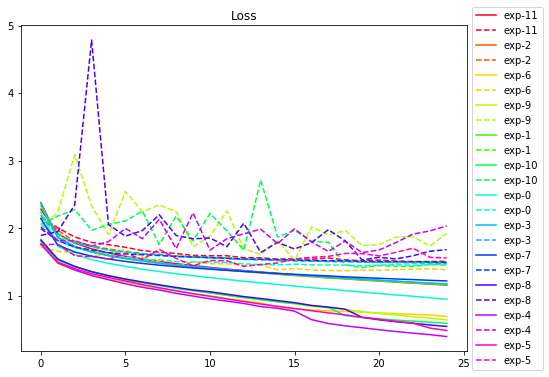

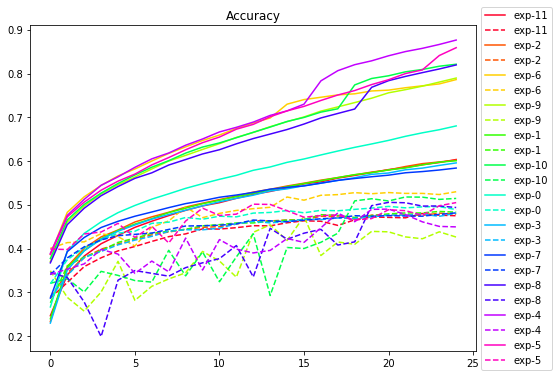

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()